<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/vgg19_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

 97% 472M/486M [00:03<00:00, 146MB/s]
100% 486M/486M [00:03<00:00, 140MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
!rm /content/ECG_Image_data/train/F/*
!rmdir /content/ECG_Image_data/train/F

In [12]:
!rm /content/ECG_Image_data/test/F/*
!rmdir /content/ECG_Image_data/test/F

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [14]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [15]:
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/N/1846.jpg,N
1,/content/ECG_Image_data/train/N/22590.jpg,N
2,/content/ECG_Image_data/train/N/29074.jpg,N
3,/content/ECG_Image_data/train/N/16572.jpg,N
4,/content/ECG_Image_data/train/N/72132.jpg,N
...,...,...
97131,/content/ECG_Image_data/train/V/3904.jpg,V
97132,/content/ECG_Image_data/train/V/280.jpg,V
97133,/content/ECG_Image_data/train/V/3312.jpg,V
97134,/content/ECG_Image_data/train/V/3437.jpg,V


In [16]:
dataframe['Label'].value_counts()

N    72471
M     8000
Q     6431
V     5788
F     2223
S     2223
Name: Label, dtype: int64

In [17]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(1600, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

V    1600
N    1600
Q    1600
F    1600
M    1600
S    1600
Name: Label, dtype: int64

In [18]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/V/1897.jpg,V
1,/content/ECG_Image_data/train/N/10200.jpg,N
2,/content/ECG_Image_data/train/Q/2375.jpg,Q
3,/content/ECG_Image_data/train/V/3403.jpg,V
4,/content/ECG_Image_data/train/N/30554.jpg,N
...,...,...
9595,/content/ECG_Image_data/train/F/185.jpg,F
9596,/content/ECG_Image_data/train/M/1392.jpg,M
9597,/content/ECG_Image_data/train/N/14108.jpg,N
9598,/content/ECG_Image_data/train/Q/1590.jpg,Q


In [ ]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

In [21]:
dataframe_test['Label'].value_counts()

N    18118
M     2506
Q     1608
V     1448
F      556
S      556
Name: Label, dtype: int64

In [22]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(500, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

Q    500
M    500
S    500
N    500
V    500
F    500
Name: Label, dtype: int64

In [23]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/Q/653.jpg,Q
1,/content/ECG_Image_data/test/M/434.jpg,M
2,/content/ECG_Image_data/test/S/439.jpg,S
3,/content/ECG_Image_data/test/Q/1070.jpg,Q
4,/content/ECG_Image_data/test/S/368.jpg,S
...,...,...
2995,/content/ECG_Image_data/test/V/1299.jpg,V
2996,/content/ECG_Image_data/test/F/461.jpg,F
2997,/content/ECG_Image_data/test/S/45.jpg,S
2998,/content/ECG_Image_data/test/N/4600.jpg,N


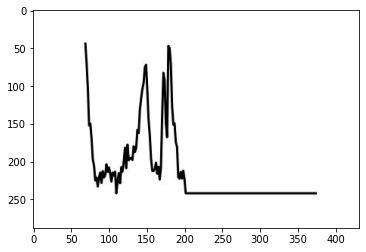

In [24]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [25]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [26]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    #shear_range = 0.2,
    #horizontal_flip=True,
    #zoom_range = 0.2,
    validation_split=0.25
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7200 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [28]:
test_generator.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

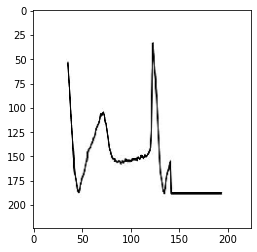

In [29]:
plt.imshow(test_generator[0][0][3])

In [30]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/F',
 '/content/ECG_Image_data/test/S',
 '/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/M',
 '/content/ECG_Image_data/test/V']

In [31]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [32]:
for layer in vgg.layers:
  layer.trainable = False

In [33]:
x = Flatten()(vgg.output)

In [34]:
prediction = Dense(len(folders), activation='softmax')(x)

In [35]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [39]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [40]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint,rp]
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8450
Epoch 1: val_accuracy improved from -inf to 0.85583, saving model to best_model.h5
225/225 [==============================] - 55s 239ms/step - loss: 0.4441 - accuracy: 0.8450 - val_loss: 0.3903 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8742
Epoch 2: val_accuracy did not improve from 0.85583
225/225 [==============================] - 54s 239ms/step - loss: 0.3521 - accuracy: 0.8742 - val_loss: 0.4354 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8883
Epoch 3: val_accuracy did not improve from 0.85583
225/225 [==============================] - 54s 239ms/step - loss: 0.3136 - accuracy: 0.8883 - val_loss: 0.4058 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 4/25
225/225 [==============================] - ETA: 0s - loss: 0.2709 - accurac

In [42]:
vgg_model.save('best.h5')

In [43]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.30760
Test Accuracy: 90.60%


In [44]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.31342
Test Accuracy: 90.67%


Text(0, 0.5, 'loss')

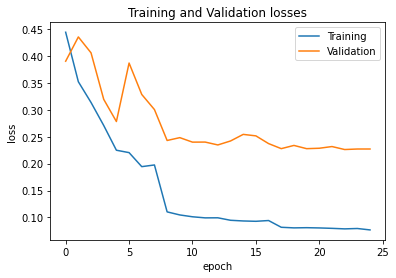

In [45]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

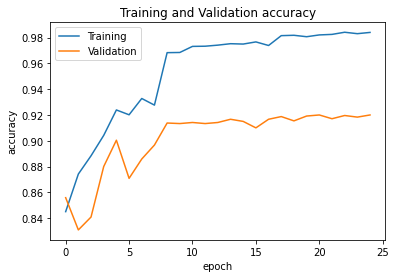

In [46]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [47]:
y_pred = best_model1.predict(test_generator)
y_pred

94/94 [==============================] - 16s 173ms/step


array([[1.3691161e-04, 7.9603546e-04, 6.7235250e-04, 9.9354386e-01,
        5.6994247e-04, 4.2808349e-03],
       [1.0236566e-03, 9.3412608e-01, 2.8423872e-03, 3.5555870e-04,
        4.7944933e-03, 5.6857787e-02],
       [4.5585420e-08, 8.0300234e-03, 8.6681382e-04, 1.2589767e-07,
        9.9110293e-01, 7.9877893e-08],
       ...,
       [1.6012369e-07, 2.5968811e-05, 2.1960986e-04, 3.6520122e-09,
        9.9956185e-01, 1.9245167e-04],
       [2.2220977e-06, 1.9426137e-01, 8.0371684e-01, 1.4397602e-04,
        9.6002273e-04, 9.1555476e-04],
       [1.6544195e-08, 8.6651416e-06, 2.4906272e-04, 1.4515726e-09,
        9.9967778e-01, 6.4503853e-05]], dtype=float32)

In [48]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 1, 4, ..., 4, 2, 4])

In [49]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[457   3  15   0   5  20]
 [  5 445  41   1   3   5]
 [  9  25 431   4  24   7]
 [  1   1   1 491   1   5]
 [  7  11  42   0 428  12]
 [ 10   5   6   3  10 466]]
classification report
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       500
           1       0.91      0.89      0.90       500
           2       0.80      0.86      0.83       500
           3       0.98      0.98      0.98       500
           4       0.91      0.86      0.88       500
           5       0.90      0.93      0.92       500

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



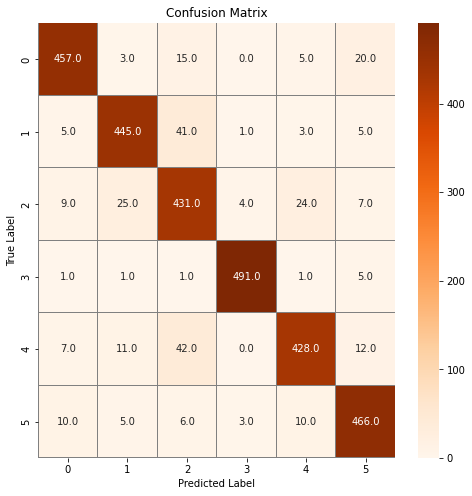

In [50]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [51]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 1s 737ms/step


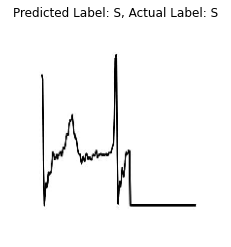

In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/S/115.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')